### **D2APR: Aprendizado de Máquina e Reconhecimento de Padrões** (IFSP, Campinas) <br/>
**Trabalho 1 - Sao Paulo Real Estate**

Aluno: Hugo Martinelli Watanuki

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>. <br/><br/>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Obtaining the dataset

About Dataset
Context
This dataset contains around 13.000 apartments for sale and for rent in the city of São Paulo, Brazil. The data comes from multiple sources, specially real estate classified websites.

Content
The dataset represents properties advertised in the month of April 2019.

2.1. Downloading the dataset

https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019/

2.2 Loading the data

In [29]:
import pandas as pd

housing = pd.read_csv('./sample_data/sao-paulo-properties-april-2019.csv')

In [2]:
housing.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


2.3. Looking a the data structure

In [87]:
housing.describe(include='all')

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
count,1.364000e+04,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.00000,13640.000000,13640,13640,13640,13640.000000,13640.000000,13640.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96,2,1,NaN,NaN,4.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moema/São Paulo,rent,apartment,NaN,NaN,2.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293,7228,13640,NaN,NaN,7057.0
mean,2.877378e+05,689.882331,84.373900,2.312023,2.073680,0.980792,1.393182,0.354179,0.146774,0.51217,0.015616,NaN,NaN,NaN,-22.077047,-43.597088,NaN
std,5.908214e+05,757.649363,58.435676,0.777461,0.961803,0.834891,0.829932,0.478281,0.353894,0.49987,0.123988,NaN,NaN,NaN,5.866633,11.487288,NaN
min,4.800000e+02,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,-46.749039,-58.364352,NaN
25%,1.858750e+03,290.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,-23.594552,-46.681671,NaN
50%,8.100000e+03,500.000000,65.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000,NaN,NaN,NaN,-23.552813,-46.637255,NaN
75%,3.600000e+05,835.000000,94.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.00000,0.000000,NaN,NaN,NaN,-23.517640,-46.560040,NaN


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished         13640 non-null  int64  
 9   Swimming Pool     13640 non-null  int64  
 10  New               13640 non-null  int64  
 11  District          13640 non-null  object 
 12  Negotiation Type  13640 non-null  object 
 13  Property Type     13640 non-null  object 
 14  Latitude          13640 non-null  float64
 15  Longitude         13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memo

Each row corresponds to one apartment and is represented by 16 attributes (9 numeric and 17 categorical).

*   Price: Final price advertised (R$ Brazilian Real)
*   Condo: Condominium expenses (unknown values are marked as zero)
*   Size: The property size in Square Meters m² (private areas only)
*   Rooms: Number of bedrooms
*   Toilets: Number of toilets (all toilets)
*   Suites: Number of bedrooms with a private bathroom (en suite)
*   Parking: Number of parking spots
*   Elevator: Binary value: 1 if there is elevator in the building, 0 otherwise
*   Furnished: Binary value: 1 if the property is funished, 0 otherwise
*   Swimming Pool: Binary value: 1 if the property has swimming pool, 0 otherwise

There are 13,640 instances in the dataset (fairly small by ML standards).
There are no missing values reported in any of the features, but the feature "Condo" has unknown values represented as zero.

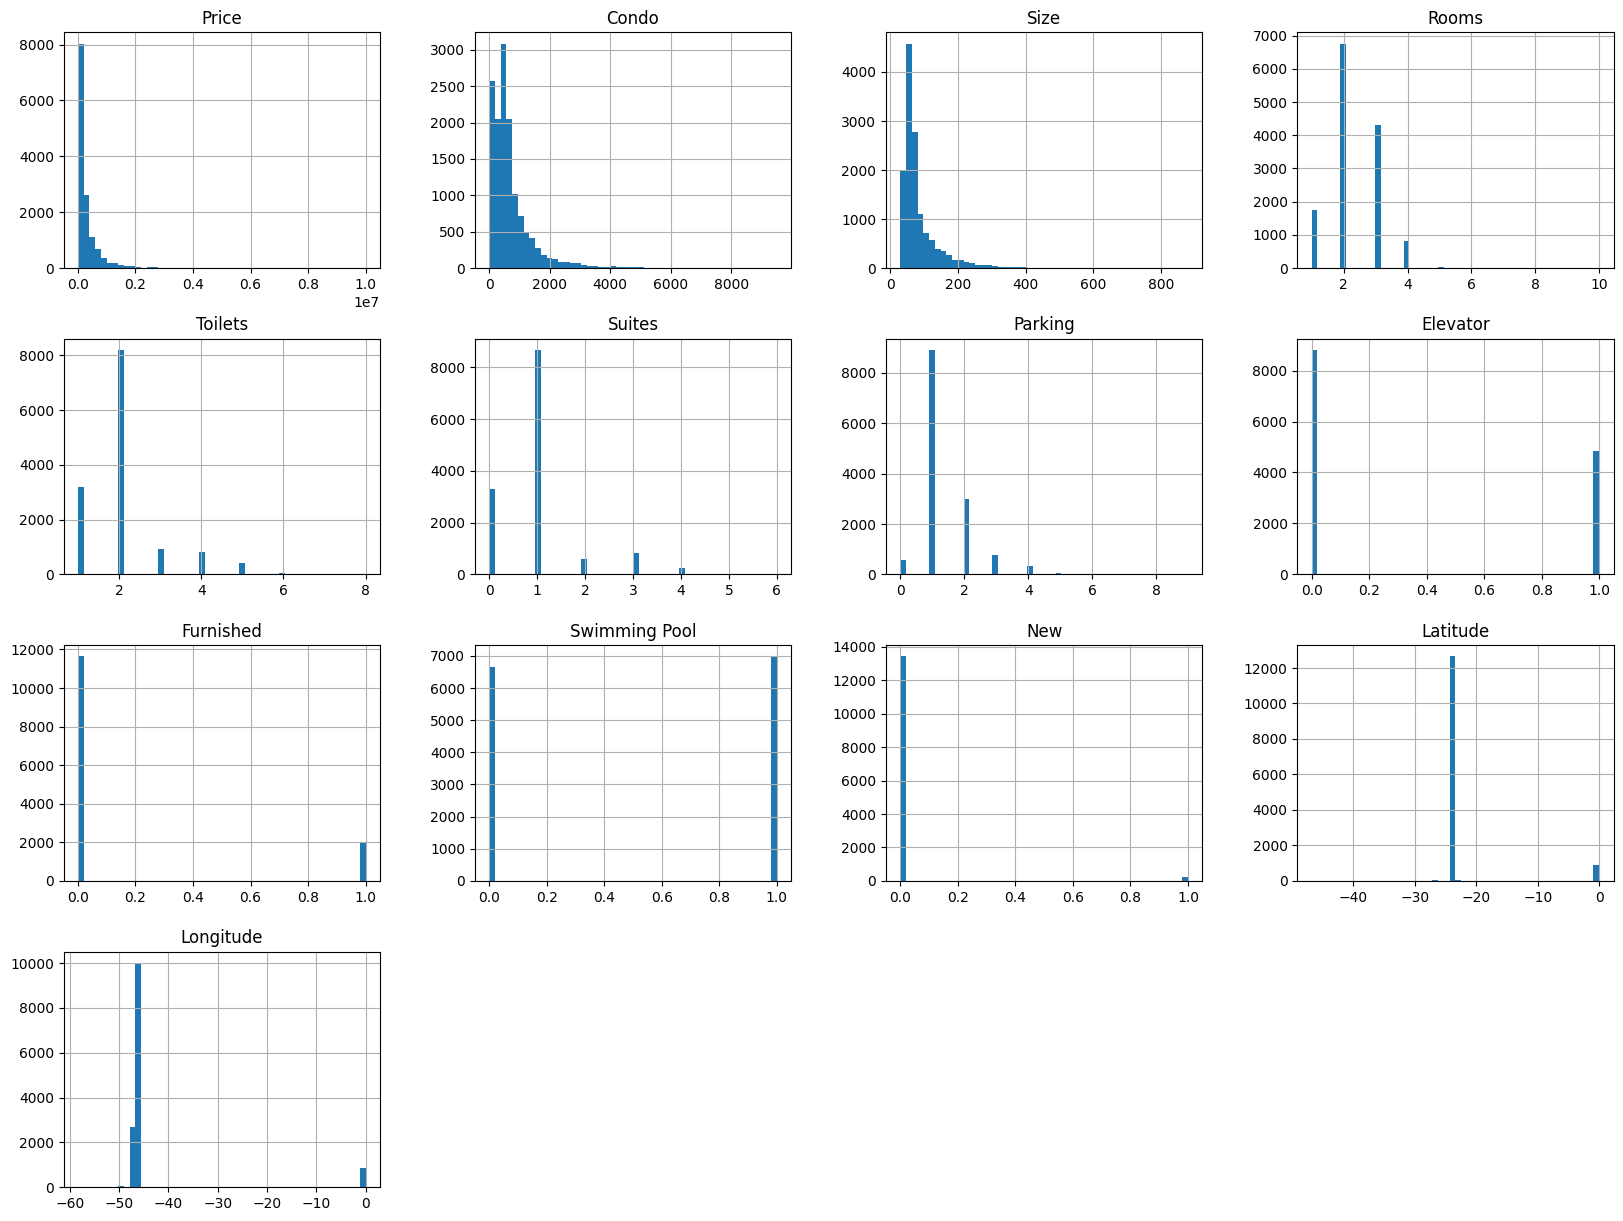

In [4]:
# plot a histogram for each numeric attibute from the dataframe
housing.hist(bins=50, figsize=(20,15))
display()  # just to avoid texts in the notebook output

In [88]:
housing['District'].value_counts()

Moema/São Paulo              293
Mooca/São Paulo              288
Brás/São Paulo               255
Brooklin/São Paulo           250
Bela Vista/São Paulo         250
                            ... 
Jardim São Luis/São Paulo     44
São Rafael/São Paulo          44
Grajaú/São Paulo              37
São Domingos/São Paulo        35
Perus/São Paulo               30
Name: District, Length: 96, dtype: int64

In [89]:
housing['Negotiation Type'].value_counts()

rent    7228
sale    6412
Name: Negotiation Type, dtype: int64

# Ps.: One specific concern for the categorial variables is that their proportions in the population are not uniform and can generate bias if proper care is not taken during sampling

## 3. Preprocessing the data

3.1 segmenting the core predictor (size)


In [91]:
housing_rent=housing[housing['Negotiation Type']=='rent']
housing_rent

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486,1
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718,1
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665,1
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014,1
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11205,3700,595,73,1,2,1,1,0,0,1,0,Brooklin/São Paulo,rent,apartment,-23.617682,-46.694963,2
11206,21000,3000,208,4,4,3,3,1,1,1,0,Brooklin/São Paulo,rent,apartment,-23.606891,-46.695934,4
11207,3800,710,55,1,1,0,1,0,1,1,0,Brooklin/São Paulo,rent,apartment,0.000000,0.000000,2
11208,5000,2354,205,3,2,1,2,1,0,0,0,Brooklin/São Paulo,rent,apartment,-23.612287,-46.681482,4


<Axes: xlabel='Size', ylabel='Count'>

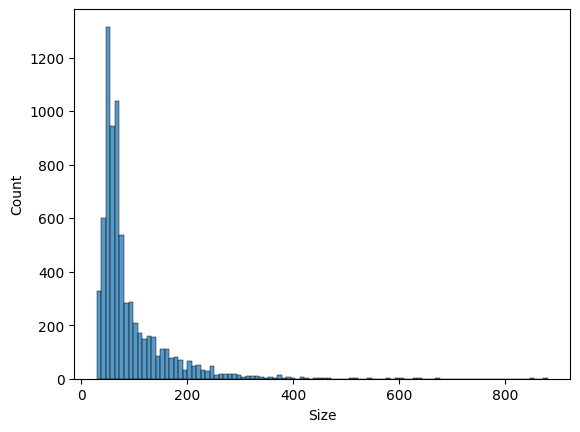

In [92]:
sns.histplot(data=housing_rent, x='Size', bins=100)

Group 1: [0, 50]
Group 2: (50, 100]
Group 3: (100, 150]
Group 4: (150, +]


In [94]:
housing_rent['Size'].describe()

count    7228.000000
mean       89.486165
std        63.976416
min        30.000000
25%        52.000000
50%        67.000000
75%       100.000000
max       880.000000
Name: Size, dtype: float64

In [97]:
housing_rent['Size_group'] = pd.cut(housing_rent['Size'], bins=[0, 50, 100, 150, np.inf],
                                        labels=[1, 2, 3, 4], include_lowest=True)

<ipython-input-97-807f7266c6b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_rent['Size_group'] = pd.cut(housing_rent['Size'], bins=[0, 50, 100, 150, np.inf],


In [96]:
housing_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486,1
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718,1
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665,1
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014,1
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436,2


In [98]:

housing_rent['Size_group'].value_counts()

2    3721
1    1727
4     920
3     860
Name: Size_group, dtype: int64

In [99]:
# proportional of the groups in the entire dataset
housing_rent['Size_group'].value_counts() / len(housing_rent['Size_group'])

2    0.514804
1    0.238932
4    0.127283
3    0.118982
Name: Size_group, dtype: float64

<Axes: xlabel='Size_group', ylabel='Count'>

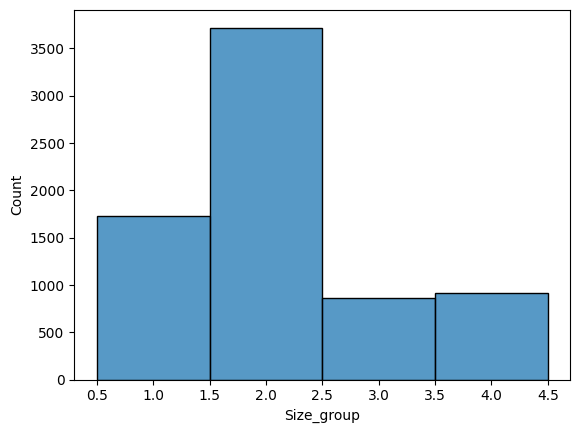

In [100]:

sns.histplot(housing_rent['Size_group'])


In [101]:
from sklearn.model_selection import train_test_split

housing_rent_train, housing_rent_test = train_test_split(housing_rent, test_size=0.2, stratify=housing_rent['Size_group'], random_state=42)

In [102]:
housing_rent_train.shape

(5782, 17)

In [103]:
housing_rent_train.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
10890,2100,597,78,3,2,1,2,0,0,1,0,Jaguaré/São Paulo,rent,apartment,-23.552138,-46.743094,2
10645,4000,1000,103,2,1,0,1,0,0,0,0,Jardim Paulista/São Paulo,rent,apartment,-23.573779,-46.654831,3
3409,3500,620,49,1,2,1,1,0,0,0,0,Campo Belo/São Paulo,rent,apartment,-23.620655,-46.677333,1
3778,4000,2700,111,2,2,1,1,0,0,0,0,Jardim Paulista/São Paulo,rent,apartment,0.000000,0.000000,3
1938,2500,465,36,1,2,1,1,1,0,1,0,Perdizes/São Paulo,rent,apartment,-23.535704,-46.672360,1


In [104]:
# proportion of the groups in the training set
housing_rent_train['Size_group'].value_counts() / len(housing_rent_train['Size_group'])

2    0.514874
1    0.238845
4    0.127292
3    0.118990
Name: Size_group, dtype: float64

In [105]:
housing_rent_test.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
3331,4000,1123,160,3,4,3,3,0,0,1,0,Cambuci/São Paulo,rent,apartment,-23.570246,-46.622185,4
3171,1500,971,95,3,2,1,2,0,0,1,0,São Lucas/São Paulo,rent,apartment,-23.586563,-46.548985,2
10803,10000,2250,208,4,5,4,4,0,0,1,0,Vila Mariana/São Paulo,rent,apartment,-23.598988,-46.633500,4
9205,2700,861,58,2,2,1,1,1,1,1,0,Liberdade/São Paulo,rent,apartment,-23.565184,-46.643505,2
1203,5800,1169,110,2,2,1,1,1,1,0,0,Jardim Paulista/São Paulo,rent,apartment,-23.568349,-46.650414,3


In [106]:
housing_rent_test.shape

(1446, 17)

In [107]:
# proportion of the groups in the testing set
housing_rent_test['Size_group'].value_counts() / len(housing_rent_test['Size_group'])

2    0.514523
1    0.239281
4    0.127248
3    0.118949
Name: Size_group, dtype: float64

In [108]:
# removing the attribute 'median_income_group'
housing_rent_train = housing_rent_train.drop(columns=['Size_group'])
housing_rent_test = housing_rent_test.drop(columns=['Size_group'])

In [109]:
# if you want to keep the reference for the row indices from the original dataset, remove the index=False
housing_rent_train.to_csv('./sample_data/housing_rent_train.csv', index=False)
housing_rent_test.to_csv('./sample_data/housing_rent_test.csv', index=False)

## 3. Data Cleaning

condo column has zero for unknown values

In [110]:
housing_rent_train['Condo'].value_counts()

0       528
500     144
600     121
400     106
450     100
       ... 
5636      1
5250      1
2256      1
313       1
906       1
Name: Condo, Length: 1096, dtype: int64

<Axes: xlabel='Condo'>

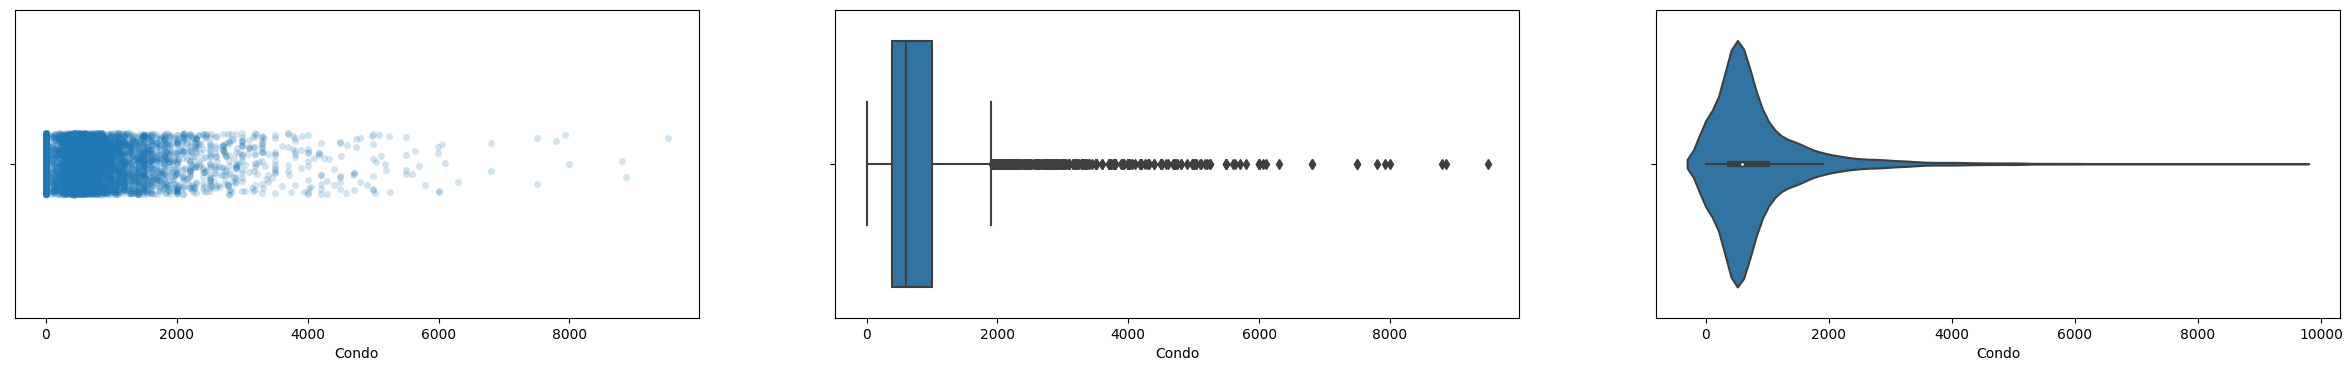

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(30, 4))

sns.stripplot(data=housing_rent_train, x='Condo', ax=axes[0], alpha=0.2)
sns.boxplot(data=housing_rent_train, x='Condo', ax=axes[1])
sns.violinplot(data=housing_rent_train, x='Condo', ax=axes[2])

In [112]:

housing_rent_train_clean = housing_rent_train.copy()

In [113]:
median_Condo = housing_rent_train_clean['Condo'].median()
median_Condo

597.0

In [114]:
mask_zeroes = housing_rent_train_clean[housing_rent_train_clean['Condo']==0]
mask_zeroes

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
10767,1500,0,40,1,1,0,1,0,0,0,0,Saúde/São Paulo,rent,apartment,-23.614958,-46.622913
9684,1200,0,42,2,2,1,1,1,0,1,0,Itaquera/São Paulo,rent,apartment,-23.560670,-46.450742
1715,1400,0,52,2,2,1,1,1,0,0,0,Butantã/São Paulo,rent,apartment,-23.580896,-46.773719
1584,5000,0,128,3,4,1,3,0,1,1,0,Alto de Pinheiros/São Paulo,rent,apartment,-23.538675,-46.713429
10207,900,0,49,2,2,1,1,0,0,0,0,Raposo Tavares/São Paulo,rent,apartment,-23.603123,-46.797977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,8000,0,273,10,4,1,8,0,0,0,0,Santo Amaro/São Paulo,rent,apartment,-23.626021,-46.682821
10443,950,0,56,2,1,0,1,0,0,0,0,José Bonifácio/São Paulo,rent,apartment,-23.547159,-46.437578
1258,8000,0,373,4,6,4,4,0,0,1,0,Morumbi/São Paulo,rent,apartment,-23.622943,-46.735851
899,1200,0,90,2,2,1,1,0,0,0,0,Capão Redondo/São Paulo,rent,apartment,-23.664693,-46.770211


In [115]:
housing_rent_train_clean['Condo'] = housing_rent_train_clean['Condo'].replace(0, median_Condo)





In [116]:
mask_zeroes = housing_rent_train_clean[housing_rent_train_clean['Condo']==0]
mask_zeroes

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude


In [118]:
housing_rent_train_clean.loc[10767]

Price                          1500
Condo                           597
Size                             40
Rooms                             1
Toilets                           1
Suites                            0
Parking                           1
Elevator                          0
Furnished                         0
Swimming Pool                     0
New                               0
District            Saúde/São Paulo
Negotiation Type               rent
Property Type             apartment
Latitude                 -23.614958
Longitude                -46.622913
Name: 10767, dtype: object

In [119]:
housing_rent_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 10890 to 2410
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             5782 non-null   int64  
 1   Condo             5782 non-null   int64  
 2   Size              5782 non-null   int64  
 3   Rooms             5782 non-null   int64  
 4   Toilets           5782 non-null   int64  
 5   Suites            5782 non-null   int64  
 6   Parking           5782 non-null   int64  
 7   Elevator          5782 non-null   int64  
 8   Furnished         5782 non-null   int64  
 9   Swimming Pool     5782 non-null   int64  
 10  New               5782 non-null   int64  
 11  District          5782 non-null   object 
 12  Negotiation Type  5782 non-null   object 
 13  Property Type     5782 non-null   object 
 14  Latitude          5782 non-null   float64
 15  Longitude         5782 non-null   float64
dtypes: float64(2), int64(11), object(3)
me

### 0. Imports and default settings for plotting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## 🛠️ 5. Prepare the Data

We will consider the same two scenarios for **Polynomial Regression** from Sprint #5 in this sprint:
1. Use _only_ the `median_income`.
2. Use _all features_ except those that generated the aggregate features (`total_rooms`, `total_bedrooms`, `population`, `household`).

### 5.1. Load the cleaned training set

Let's consider the training and testing sets already cleaned (sprint #2):
- Drop duplicated instances (no found)
- Drop instances with `housing_median_age` capped at 52
- Drop instances with `median_house_value` capped at 500001.0

In [ ]:
# load the cleaned training set
housing_train = pd.read_csv('./datasets/housing_train_sprint-2.csv')

In [ ]:
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.37,37.06,25.0,474.0,92.0,300.0,104.0,3.8062,340900.0,INLAND
1,-118.39,34.14,19.0,5076.0,1034.0,2021.0,960.0,5.5683,309200.0,<1H OCEAN
2,-122.07,37.41,26.0,1184.0,225.0,815.0,218.0,5.7657,322300.0,NEAR BAY
3,-121.92,36.57,42.0,3944.0,738.0,1374.0,598.0,4.1740,394400.0,NEAR OCEAN
4,-118.36,33.82,36.0,1083.0,187.0,522.0,187.0,5.7765,339500.0,<1H OCEAN


In [ ]:
housing_train.shape

(14857, 10)

### 5.2. Separate the _features_ and the _target outcome_

In [ ]:
# store the target outcome into a numpy array
y_train = housing_train['median_house_value'].values

# overwrite the dataframe with only the features
housing_train = housing_train.drop(columns=['median_house_value'])

### 5.3. Pipelines

For the sake of simplicity, let's include the **Polynomial Regression** objects (`PolynomialFeatures()` + `LinearRegression()`) into our **pipeline**. So, it is no longer _just_ dedicated to preprocessing.

#### **Scenario 1**

In [ ]:
# pipeline for numerical
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

attributes_scenario_1 = ['median_income']

pipeline_scenario_1 = Pipeline([
    ('imputer', SimpleImputer()),   # let's evaluate the mean and median inputation
    ('poly', PolynomialFeatures()),
    ('scaler', RobustScaler())
])

# we will just use the ColumnTransformer because it automaticaly filters the required columns for us before performing the pipeline.
# (name, transformer, columns)
preprocessed_pipeline_scenario_1 = ColumnTransformer([
    ("numerical", pipeline_scenario_1, attributes_scenario_1)
])


# full pipeline: preprocessing + model training/prediction
full_pipeline_scenario_1 = Pipeline([
        ('preprocessing', preprocessed_pipeline_scenario_1),
        ('lin_regression', LinearRegression())
])

#### **Scenario 2**

In [ ]:
#### feature engineering method from the Sprint #4
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# our 3 new features are based on some the features: totalrooms,
# column index
rooms_col_idx, bedrooms_col_idx, population_col_idx, households_col_idx = 3, 4, 5, 6

class HousingFeatEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        n_rows = X.shape[0]

        # creating the new features
        rooms_per_household = X[:, rooms_col_idx] / X[:, households_col_idx]
        population_per_household = X[:, population_col_idx] / X[:, households_col_idx]
        bedrooms_per_room = X[:, bedrooms_col_idx] / X[:, rooms_col_idx]

        # to concatenate the new array as columns in our feature matrix, we need to reshape them first
        rooms_per_household = rooms_per_household.reshape((n_rows, 1))
        population_per_household = population_per_household.reshape((n_rows, 1))
        bedrooms_per_room = bedrooms_per_room.reshape((n_rows, 1))

        # concatenating the new features into the feature matrix
        X_out = np.hstack((X, rooms_per_household, population_per_household, bedrooms_per_room))

        return X_out

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# our 3 new features are based on some the features: totalrooms,
# column index
rooms_col_idx, bedrooms_col_idx, population_col_idx, households_col_idx = 3, 4, 5, 6

class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        X_out = np.delete(X, [rooms_col_idx, bedrooms_col_idx, population_col_idx, households_col_idx], axis=1)

        # for debugging
        if self.verbose:
            np.set_printoptions(suppress=True)
            print('X[:5]')
            print(X[:5])
            print('\nX_out[:5]')
            print(X_out[:5])

        return X_out

In [ ]:
# pipeline for numerical
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

attributes_scenario_2 = housing_train.columns.drop('ocean_proximity')

pipeline_scenario_2 = Pipeline([
    ('imputer', SimpleImputer()),  # let's evaluate the mean and median inputation
    ('feat_engineering', HousingFeatEngineering()),
    ('drop_features', DropFeatures(verbose=False)),
    ('poly', PolynomialFeatures()),
    ('scaler', RobustScaler())
])

# we will just use the ColumnTransformer because it automaticaly filters the required columns for us before performing the pipeline.
# (name, transformer, columns)
preprocessed_pipeline_scenario_2 = ColumnTransformer([
    ("numerical", pipeline_scenario_2, attributes_scenario_2)
])

# full pipeline: preprocessing + model training/prediction
full_pipeline_scenario_2 = Pipeline([
        ('preprocessing', preprocessed_pipeline_scenario_2),
        ('lin_regression', LinearRegression())
])

## 🏋️‍♀️ 6. Train ML Algorithms

### 6.1. Grid-Search (fine-tunning)
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

### **Scenario 1**

#### **Finding out the hyperparameter key names**

In [ ]:
full_pipeline_scenario_1.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('numerical',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('poly', PolynomialFeatures()),
                                                    ('scaler', RobustScaler())]),
                                    ['median_income'])])),
  ('lin_regression', LinearRegression())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('numerical',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('poly', PolynomialFeatures()),
                                                  ('scaler', RobustScaler())]),
                                  ['median_income'])]),
 'lin_regression': LinearRegression(),
 'preprocessing__n_jobs': None,
 'preprocessing__remainder': 'drop',
 'preprocessing__sparse_threshold': 0.3,
 'preprocessing__transfor

#### **Grid-search**

In [ ]:
from sklearn.model_selection import GridSearchCV

# search space
param_grid_scenario_1 = [
    {
    'preprocessing__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessing__numerical__poly__degree': [2, 3, 10, 20, 30],
    'preprocessing__numerical__poly__include_bias': [False, True],
    'preprocessing__numerical__poly__interaction_only': [False, True]
    }
]

grid_search_scenario_1 = GridSearchCV(full_pipeline_scenario_1, param_grid_scenario_1, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=1)
grid_search_scenario_1.fit(housing_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['median_income'])])),
                                       ('lin_regression', LinearRegression())]),
             param_grid=[{'prepr

In [ ]:
cvres = grid_search_scenario_1.cv_results_

# (approximated) RMSE
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

71691.10772210758 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 2, 'preprocessing__numerical__poly__include_bias': False, 'preprocessing__numerical__poly__interaction_only': False}
71676.82921015851 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 2, 'preprocessing__numerical__poly__include_bias': False, 'preprocessing__numerical__poly__interaction_only': True}
71691.10772210758 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 2, 'preprocessing__numerical__poly__include_bias': True, 'preprocessing__numerical__poly__interaction_only': False}
71676.82921015852 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 2, 'preprocessing__numerical__poly__include_bias': True, 'preprocessing__numerical__poly__interaction_only': True}
71456.56128983348 {'preprocessing__numerical__imputer__strategy': 'mean'

In [ ]:
# best params
grid_search_scenario_1.best_params_

{'preprocessing__numerical__imputer__strategy': 'mean',
 'preprocessing__numerical__poly__degree': 10,
 'preprocessing__numerical__poly__include_bias': False,
 'preprocessing__numerical__poly__interaction_only': False}

In [ ]:
# best estimator
# if refit=True, it returns a model trained with the full training set with the best hyperparameters
best_model = grid_search_scenario_1.best_estimator_
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=10,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['median_income'])])),
                ('lin_regression', LinearRegression())])

In [ ]:
# get the (approximated) RMSE
np.sqrt(-grid_search_scenario_1.best_score_)

71298.70981488981

In [ ]:
# get the approximated RMSE and its standard deviation
best_index = grid_search_scenario_1.best_index_
best_score = np.sqrt(-grid_search_scenario_1.cv_results_['mean_test_score'][best_index])
best_score_std = np.sqrt(grid_search_scenario_1.cv_results_['std_test_score'][best_index])

print(f'Best score: {best_score} +- {best_score_std}')

Best score: 71298.70981488981 +- 11036.55480104328


<br/>

The **cross validation score** from **the best model** (\\$71,298.70 ± \\$11,036.55) is _slightly better_ than the score of Scenario 1 without fine-tunning (\\$71,671.86 ± \$1,479.30) from Sprint #5, its results are more unstable (see its _standard deviation_). <br/>
Moreover, its **cross validation score** keeps being _considerably higher_ than that of `Linear Regression` from the previous Sprint (\\$58,371.04 ± \$1,757.91).

<table align="left" class="dashed-box">
<tr>
    <td>💡</td>
    <td>Mathematically, the correct way to estimate the <b>cross-validation RMSE</b> and its <b>standard deviation</b> is to apply the <i>square root</i> for the each split <i>negative MSE score</i>, and then compute the <i>mean</i> and <i>std</i> with these new scores.</td>
</tr>
<tr>
    <td></td>
    <td>For that, we need to 'debug' the _cross validation results.</td>
</tr>
</table><br/><br/>

In [ ]:
grid_search_scenario_1.cv_results_

{'mean_fit_time': array([0.01887522, 0.0094492 , 0.00991473, 0.01025591, 0.01390386,
        0.01003895, 0.01409917, 0.01014118, 0.01996737, 0.01102452,
        0.02211404, 0.01221519, 0.03636308, 0.0101171 , 0.033359  ,
        0.01285214, 0.04814892, 0.0117455 , 0.04784751, 0.01231089,
        0.01181126, 0.00959897, 0.01091461, 0.01017919, 0.01351895,
        0.00950961, 0.01344018, 0.0112464 , 0.02205029, 0.01144061,
        0.02214503, 0.01309052, 0.04201412, 0.01209021, 0.04594536,
        0.01328597, 0.04784422, 0.01263294, 0.04693222, 0.01277361]),
 'std_fit_time': array([0.00306254, 0.00147188, 0.00059162, 0.00081139, 0.00206498,
        0.00197489, 0.00128092, 0.00131696, 0.00153409, 0.00047527,
        0.00095572, 0.00066597, 0.00206565, 0.00020597, 0.00272837,
        0.00068374, 0.00365625, 0.00205953, 0.00321318, 0.00097735,
        0.00085682, 0.00073027, 0.00043163, 0.00048236, 0.00191204,
        0.00091917, 0.00098501, 0.00108267, 0.00116167, 0.00019569,
        0.001

In [ ]:
n_folds = 5
split_keys = [f'split{i}_test_score' for i in range(n_folds)]
best_index = grid_search_scenario_1.best_index_

rmse_scores = []

for key in split_keys:
    neg_mse_score = grid_search_scenario_1.cv_results_[key][best_index]
    rmse_scores.append(np.sqrt(-neg_mse_score))

best_rmse = np.mean(rmse_scores)
best_rmse_std = np.std(rmse_scores)


print(f'Best RMSE score: {best_rmse} +- {best_rmse_std}')

Best RMSE score: 71293.59154095282 +- 854.2988116844386


By doing it in the _mathematically correct way_, we see that the **true mean RMSE** (\\$71,293.59) is very close from the approximated one (\\$71,298.70). <br/>
However, the **true standard deviation for RMSE** (\$854.29) is _considerably smaller_ than the approximated one (\\$11,036.55).

### **Scenario 2**

In [ ]:
full_pipeline_scenario_2.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('numerical',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('feat_engineering',
                                                     HousingFeatEngineering()),
                                                    ('drop_features',
                                                     DropFeatures()),
                                                    ('poly', PolynomialFeatures()),
                                                    ('scaler', RobustScaler())]),
                                    Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
          'total_bedrooms', 'population', 'households', 'median_income'],
         dtype='object'))])),
  ('lin_regression', LinearRegression())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('numerical',
                             

Since our feature matrix has a considerable number of features, for computation time reasons, we decided to:
- Consider a small number of hyperparameter combinations (small search space)
- Low polynomial degrees

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_scenario_2 = [
    {
     'preprocessing__numerical__imputer__strategy': ['mean', 'median'],
     'preprocessing__numerical__poly__degree': [2, 3, 4, 5],
     'preprocessing__numerical__poly__include_bias': [False, True],
     'preprocessing__numerical__poly__interaction_only': [False]
    }
]

grid_search_scenario_2 = GridSearchCV(full_pipeline_scenario_2, param_grid_scenario_2, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=1)
grid_search_scenario_2.fit(housing_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('feat_engineering',
                                                                                          HousingFeatEngineering()),
                                                                                         ('drop_features',
                                                                                          DropFeatures()),
                                                                                         ('poly',
                                                                                          

In [ ]:
cvres = grid_search_scenario_2.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

626165.2300283933 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 2, 'preprocessing__numerical__poly__include_bias': False, 'preprocessing__numerical__poly__interaction_only': False}
626165.2300291593 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 2, 'preprocessing__numerical__poly__include_bias': True, 'preprocessing__numerical__poly__interaction_only': False}
206771298.9577116 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 3, 'preprocessing__numerical__poly__include_bias': False, 'preprocessing__numerical__poly__interaction_only': False}
206771298.9352535 {'preprocessing__numerical__imputer__strategy': 'mean', 'preprocessing__numerical__poly__degree': 3, 'preprocessing__numerical__poly__include_bias': True, 'preprocessing__numerical__poly__interaction_only': False}
94247368586.192 {'preprocessing__numerical__imputer__strategy': 'mean'

In [ ]:
grid_search_scenario_2.best_params_

{'preprocessing__numerical__imputer__strategy': 'mean',
 'preprocessing__numerical__poly__degree': 2,
 'preprocessing__numerical__poly__include_bias': False,
 'preprocessing__numerical__poly__interaction_only': False}

In [ ]:
# if refit=True, it returns a model trained with the full training set with the best hyperparameters
best_model = grid_search_scenario_2.best_estimator_
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('feat_engineering',
                                                                   HousingFeatEngineering()),
                                                                  ('drop_features',
                                                                   DropFeatures()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                             

In [ ]:
# best approximated RMSE
np.sqrt(-grid_search_scenario_2.best_score_)

626165.2300283933

In [ ]:
# get the approximated RMSE and its standard deviation
best_index = grid_search_scenario_2.best_index_
best_score = np.sqrt(-grid_search_scenario_2.cv_results_['mean_test_score'][best_index])
best_score_std = np.sqrt(grid_search_scenario_2.cv_results_['std_test_score'][best_index])

print(f'Best score: {best_score} +- {best_score_std}')

Best score: 626165.2300283933 +- 874997.3364957358


In [ ]:
n_folds = 5
split_keys = [f'split{i}_test_score' for i in range(n_folds)]
best_index = grid_search_scenario_2.best_index_

rmse_scores = []

for key in split_keys:
    neg_mse_score = grid_search_scenario_2.cv_results_[key][best_index]
    rmse_scores.append(np.sqrt(-neg_mse_score))

best_rmse = np.mean(rmse_scores)
best_rmse_std = np.std(rmse_scores)


print(f'Best RMSE score: {best_rmse} +- {best_rmse_std}')

Best RMSE score: 345172.7167522515 +- 522435.34614953154


<br/>

The large **best true RMSE** (\\$345,172.71) -- even larger for the approximated one (\\$626,165.23) -- shows that (i) this model is not suitable for the problem, and/or (ii) the considered _search space_ is insufficient to get better models. <br/>

We'd better throw this model away.